# Unsupervised Machine Learning Exercise

**Lecturer**: Ashish Mahabal<br>
**Jupyter Notebook Author**: Umaa Rebbapragada, modified by Ashish Mahabal.

This is a Jupyter notebook lesson extending the LSSTC Data Science Fellowship Program (https://ciera.northwestern.edu/programs/lsstc-data-science-fellowship-program/) Nov 2018 edition (session 7) and adapted for the NARIT-EACOA 2019 summer workshop.

## Objective

* Become familiar with the ZTF data, the examination of some of its features
* Cluster a set of candidate sources from the Zwicky Transient Facility's (ZTF) image subtraction pipeline.  All candidate features and postage stamps were extracted from ZTF's public alert stream. 
* Run sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) algorithm on 2 or more features.  

## Key steps

1. Load data
2. Plot Features 'elong' and 'chipsf'
3. Run KMeans on 2 Features
4. Feature Scaling
4. Evaluation Results Quantitatively
5. Evaluate Results by Examining Postage Stamps
6. Clustering in a Dimensionally-Reduced Space


## Required dependencies

Nominally, you should be able to install the python modules with `pip install <module>`.  The external astromatic packages are easiest installed using package managers (e.g., `rpm`, `apt-get`).

### Python modules
* python 3
* astropy
* numpy
* matplotlib
* scikit-learn

### External packages
None

### 0a. Imports

These are all the imports that will be used in this notebook.  All should be available in the DSFP conda environment.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from time import time
from matplotlib.pyplot import imshow
from matplotlib.image import imread
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances

### 0b. Data Location

You will need the following files in a subdir called data:
- dsfp_ztf_meta.npy
- dsfp_ztf_feats.npy
- dsfp_ztf_png_stamps.tgz

You will need to unzip and unpack this last file (a "tarball") called `dsfp_ztf_png_stamps.tar.gz`. Run the following commands in the data subdirectory of this notebook to unpack the png stamps:

 - tar -xzvf dsfp_ztf_png_stamps.tgz
 
You should now have a subdirectory in your data directory called dsfp_ztf_png_stamps.

Please specify the following file locations:

In [2]:
F_META = 'data/dsfp_ztf_meta.npy'
F_FEATS = 'data/dsfp_ztf_feats.npy'
D_STAMPS = 'data/dsfp_ztf_png_stamps.tgz'


## 1. Load Data

We are ready to get started! :)  Start by loading the data and confirming that feats has the same number of columns as COL_NAMES.  Please note that the last columns is a class label with values {0, 1}, where 0=bogus, and 1=real.  Today we are doing unsupervised learning, but some clustering evaluation methods use labels to quantitatively measure the quality of the clustering result.

In [3]:
meta = np.load(F_META, allow_pickle=True)
feats = np.load(F_FEATS, allow_pickle=True)

COL_NAMES = ['diffmaglim', 'magpsf', 'sigmapsf', 'chipsf', 'magap', 'sigmagap',
             'distnr', 'magnr', 'sigmagnr', 'chinr', 'sharpnr', 'sky',
             'magdiff', 'fwhm', 'classtar', 'mindtoedge', 'magfromlim', 'seeratio',
             'aimage', 'bimage', 'aimagerat', 'bimagerat', 'elong', 'nneg',
             'nbad', 'ssdistnr', 'ssmagnr', 'sumrat', 'magapbig', 'sigmagapbig',
             'ndethist', 'ncovhist', 'jdstarthist', 'jdendhist', 'scorr', 'label']
             
# INSTRUCTION: Verify that feats has the same number of columns as COL_NAMES
print(feats.shape)
print(len(COL_NAMES))

(3190, 36)
36


## 2. Plot Features

We will perform K-means clustering using two features: 'chipsf' and 'elong'.  Chipsf is the uncertainty associated with performing PSF-fit photometry.  The higher the chi values, the more uncertainty associated with the source's PSF fit. Elong is a measure of how elongated the source is.  A transient point source should have a spherical point spread function.  An elongated point source may be a sign of a problem with image subtraction.

Extract features chipsf and along from the data.  Scatter plot them together, and also plot their histograms.  

#### Question: What do you notice about these features?


In [4]:
featnames_to_select = ['chipsf', 'elong']

# Extract the Correct Features
# 
featidxs_to_select_indices = [ COL_NAMES.index(x) for x in featnames_to_select]
feats_selected = feats[:,featidxs_to_select_indices]

# Scatter Plot the Two Features
#
def plot_scatter(dat, xlabel, ylabel, xscale='linear', yscale='linear'):
    plt.plot(dat[:,0], dat[:,1], 'k.')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.show()
    
# Scatter Plot the Two Features
#
def plot_histogram(dat, bins, title, xscale='linear', yscale='linear'):
    plt.hist(dat, bins)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(title)
    plt.show()

# INSTRUCTION: Scatter Plot the Data
# 

# INSTRUCTION: Plot the Histograms for both features.  Hint, it may be helpful to plot some features on a log scale.
# 

In [5]:
feats_selected.shape

(3190, 2)

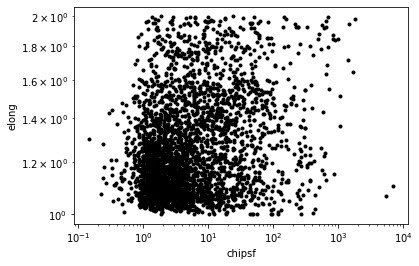

In [6]:
plot_scatter(feats_selected, featnames_to_select[0], featnames_to_select[1], xscale='log', yscale='log')

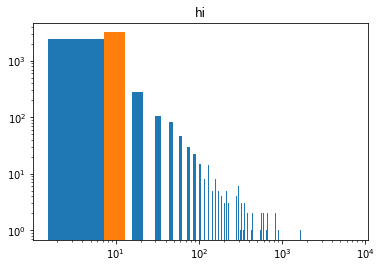

In [7]:
plot_histogram(feats_selected, 500, 'hi', xscale='log', yscale='log')

## 3. KMeans Using Two Features

We rarely ever cluster only two features from a dataset.  However, the advantage of doing so is that we can readily visualize two-dimensional data.  Let's start off by clustering features elong and chipsf with KMeans.  The plotKMeans function below implements a visualization of KMean's partitioning that was used in sklearn's [KMean's demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html).  

#### Question: What do you think about the quality of the clusterings produced?

In [8]:

def runKMeans(dat, n_clusters=2, seed=0):
        return KMeans(n_clusters, random_state=seed).fit(dat) 

def plotKMeans(kmeans_res, reduced_dat, xlabel, ylabel, xscale='linear', yscale='linear'):
    
    # Plot the decision boundary. For that, we will assign a color to each
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = reduced_dat[:, 0].min() - 1, reduced_dat[:, 0].max() + 1
    y_min, y_max = reduced_dat[:, 1].min() - 1, reduced_dat[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans_res.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')
    plt.plot(reduced_dat[:,0], reduced_dat[:,1], 'k.')
    plt.scatter(kmeans_res.cluster_centers_[:, 0], kmeans_res.cluster_centers_[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.show()

# INSTRUCTION: Use the runKMeans and plotKMeans functions to cluster the data (feats_selected)
# with several values of k.  


In [9]:
km = runKMeans(feats_selected, n_clusters=2)

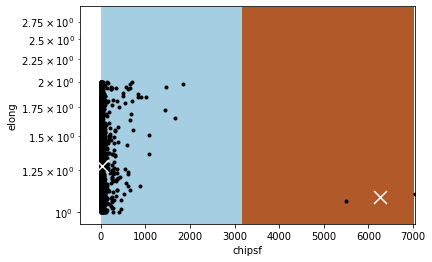

In [10]:
plotKMeans(km, feats_selected, featnames_to_select[0], featnames_to_select[1], xscale='linear', yscale='log')

# 4. Feature Scaling

We just discovered that distance metrics can be sensitive to the scale of your data (e.g., some features span large numeric ranges, but others don't).  For machine learning methods that calculate similiarty between feature vectors, it is important to normalize data within a standard range such as (0, 1) or with z-score normalization (scaling to unit mean and variance).  Fortunately, sklearn also makes this quite easy.  Please review sklearn's [preprocessing](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) module options, specifically StandardScaler which corresponds to z-score normalization and MinMaxScaler.  Please implement one. 

After your data has been scaled, scatter plot your rescaled features, and run KMeans with the transformed data.  Compare the results on the transformed data with those above.

StandardScaler mean:  [29.17139194  1.2778018 ]
[[-0.15462825  0.45113606]
 [-0.15113507 -0.38585621]
 [-0.15081031  0.67781585]
 ...
 [-0.12614616 -0.46078562]
 [-0.14752673 -0.44320945]
 [-0.13731101 -0.70536211]]


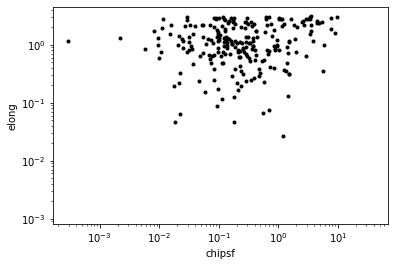

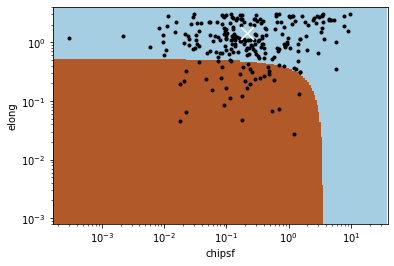

In [11]:
# INSTRUCTION: Re-scale your data using either the MinMaxScaler or StandardScaler from sklearn
#

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feats_selected_scaled = scaler.fit_transform(feats_selected)
print("StandardScaler mean: ", scaler.mean_)
print(feats_selected_scaled)

# INSTRUCTION: Scatter plot your rescaled data
#

plot_scatter(feats_selected_scaled, featnames_to_select[0], featnames_to_select[1], xscale='log', yscale='log')

# INSTRUCTION: Retry KMeans with the same values of k used above.
#

km = runKMeans(feats_selected_scaled, n_clusters=2)
plotKMeans(km, feats_selected_scaled, featnames_to_select[0], featnames_to_select[1], xscale='log', yscale='log')

# 5. Quantitative Cluster Evaluation

So far, we've been visually verifying our clusters.  Let's use quantitative methods to verify our results. 

The following is a score that does not require labels:
- inertia: "Sum of squared distances of samples to their closest cluster center."
- Silhouette coefficient: Measures minimal inertia in ratio to distance to next nearest cluster.  The score is higher are clusters become more compact and well-separated.

The following scores do require labels, and are documented [here](http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation).

- ARI, AMI measure the similarity between ground_truth labels and predicted_labels.  ARI measure similarity, and AMI measures in terms of mutual information. Random assignments score close to 0, correct assignments close to 1.
- homogeneity: purity of the cluster (did all cluster members have the same label?). Scores in [0,1] where 0 is bad.
- completeness: did all labels cluster together in a single cluster? Scores in [0,1] where 0 is bad.


In [12]:
# extract labels
label_idxs = COL_NAMES.index('label')
feat_labels = feats[:,label_idxs]

print(feat_labels.shape)

(3190,)


In [13]:
sample_size = 300

def bench_k_means(estimator, name, data, labels):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

labels = feats[:,-1]
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

# INSTRUCTIONS: Use the bench_k_means method to compare your clustering results
#


__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette


In [14]:
bench_k_means(km, 'kmeans', feats_selected_scaled, feat_labels)

kmeans   	0.17s	4047	0.109	0.111	0.110	-0.058	0.110	0.630


# 6.  Cluster Evaluation by Visual Inspection

## This time with postage stamps!

It can be tempting to let yourself be guided by metrics alone, and the metrics are useful guideposts that can help determine whether you're moving in the right direction.  However, the goal of clustering is to reveal structure in your dataset.  Fortunately, because the features were extracted from sources that were extracted from images, we can view the cutouts from each source to visually verify whether our clusters contain homogeneous objects.  

The display methods below give you an opportunity to display random candidates from each cluster, or the candidates that are closest to the cluster center.

In [23]:

def display_stamps(candids, fig_title):
    
    # display five across
    num_per_row = 5
    
    for i, candid in enumerate(candids):
        f_stamp = glob.glob(os.path.join(D_STAMPS, 'candid{}*.png'.format(candid)))[0] # there should only be one file returned!
        if (i % num_per_row) == 0:
            fig = plt.figure(figsize=(18, 3))
            fig.suptitle(fig_title)        

        ax = fig.add_subplot(1, num_per_row, i%num_per_row + 1)
        ax.set_axis_off()
        ax.set_title(candid)
        stamp = imread(f_stamp)
        imshow(stamp)
    return

def closest_to_centroid(centroid, cluster_feats, cluster_candids):
    
    dists = euclidean_distances(cluster_feats, centroid.reshape(1, -1))[:,0]
    closest_indices = np.argsort(dists)[:10]
    return cluster_candids[closest_indices]

def show_cluster_stamps(kmeans_res, displayMode='closest', num_to_display=10):
    # spits out a random selection of stamps from each cluster
    
    
    for i in range(kmeans_res.n_clusters):
        centroid = kmeans_res.cluster_centers_[i, :]
        mask = kmeans_res.labels_ == i
        cluster_candids = meta[mask]['candid']
        cluster_feats = feats_selected_scaled[mask]
        if displayMode == 'near_centroid':
            selected_candids = closest_to_centroid(centroid, cluster_feats, cluster_candids)
        if displayMode == 'random':
            np.random.shuffle(cluster_candids)
            selected_candids = cluster_candids[:num_to_display]
        display_stamps(selected_candids, 'Cluster {}'.format(i))

# INSTRUCTION: Use the show_cluster_stamps method to display cutouts associated with each cluster.
# Do you see similar objects in each cluster?
#


In [27]:
show_cluster_stamps(km, displayMode='near_centroid', num_to_display=10)

IndexError: list index out of range

# 7.  Clustering in a Dimensionally-Reduced Space

Given the tools seen above, starting clustering more than 2 features at a time.  This work is free-form.  I'll start you off with some suggested features.  After plotting the feature distributions, you may choose to down-select further.

Because we're now working with more than 2 features, use PCA to project the feature space onto its first two principal components.  You may use the methods above to run KMeans in that reduced feature space and evaluate your results.

In [28]:
featnames_to_select = ['chipsf', 'elong', 'diffmaglim', 'magpsf', 'sigmapsf', 
                       'chipsf', 'magap', 'sigmagap', 'sky', 'magdiff', 'fwhm', 
                       'mindtoedge', 'magfromlim', 'seeratio', 'aimage', 'bimage',
                       'aimagerat', 'bimagerat', 'elong', 'nneg', 'nbad', 'sumrat', 'magapbig', 'sigmagapbig']

# INSTRUCTION: Visualize these features.  Discard any you consider to be problematic.

# INSTRUCTION: Filter the feature space

# INSTRUCTION: Run PCA on this feature space to reduce it to 2 principal components

# INSTRUCTION: Run KMeans on this 2-dimensional PCA space, and evaluate your results both quantatively and qualitatively.

In [38]:
import pandas as pd
df = pd.DataFrame(feats)
df.columns = COL_NAMES
df

,diffmaglim,magpsf,sigmapsf,chipsf,magap,sigmagap,distnr,magnr,sigmagnr,chinr,...,ssmagnr,sumrat,magapbig,sigmagapbig,ndethist,ncovhist,jdstarthist,jdendhist,scorr,label
0,17.281851,17.551567,0.165697,0.617023,17.300800,0.2021,-999.000000,-999.000000,-999.000,-999.000,...,-999.0,0.809352,16.575399,0.2297,1.0,54.0,2.458215e+06,2.458215e+06,5.223946,0.0
1,20.320570,20.802053,0.195894,1.262091,20.366100,0.2053,8.082719,23.323999,0.351,0.744,...,-999.0,1.000000,19.654600,0.2366,1.0,60.0,2.458220e+06,2.458220e+06,5.518701,0.0
2,20.427725,20.922333,0.200625,1.322061,20.233700,0.1664,9.313808,23.226999,0.332,0.681,...,-999.0,1.000000,19.508101,0.1896,1.0,51.0,2.458220e+06,2.458220e+06,5.856411,0.0
3,20.427725,20.703472,0.172896,1.431551,20.347000,0.1857,3.687793,20.256001,0.065,2.594,...,-999.0,0.988251,19.627600,0.2118,1.0,51.0,2.458220e+06,2.458220e+06,5.573197,0.0
4,20.427725,20.704222,0.171942,1.341425,20.474501,0.2077,3.520936,21.767000,0.097,0.903,...,-999.0,0.938757,19.993799,0.2958,1.0,51.0,2.458220e+06,2.458220e+06,6.145004,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,20.448118,17.893902,0.137054,17.172440,17.895201,0.0504,0.317832,15.811000,0.019,1.046,...,-999.0,0.962659,17.888500,0.0588,12.0,67.0,2.458309e+06,2.458390e+06,5.236978,0.0
3186,20.817453,19.790672,0.179343,8.860709,19.420900,0.1340,2.760423,19.268000,0.113,6.387,...,-999.0,0.660984,19.520800,0.1836,3.0,11.0,2.458370e+06,2.458391e+06,14.190198,0.0
3187,21.153221,19.800976,0.208728,5.876659,20.515400,0.2529,1.422600,19.018000,0.059,2.474,...,-999.0,0.999012,19.728800,0.1553,14.0,139.0,2.458343e+06,2.458391e+06,7.552071,0.0
3188,20.695030,19.784037,0.148797,1.928423,19.771999,0.1807,6.561678,20.098000,0.043,0.863,...,-999.0,0.952918,19.594101,0.2094,16.0,104.0,2.458321e+06,2.458391e+06,8.503010,0.0


In [39]:
corr_matrix = df.corr()
print(corr_matrix)

             diffmaglim    magpsf  sigmapsf    chipsf     magap  sigmagap  \
diffmaglim     1.000000  0.361464  0.073366 -0.001664  0.406195  0.061730   
magpsf         0.361464  1.000000  0.629433 -0.364209  0.952330  0.621649   
sigmapsf       0.073366  0.629433  1.000000 -0.169084  0.666096  0.758424   
chipsf        -0.001664 -0.364209 -0.169084  1.000000 -0.362571 -0.168481   
magap          0.406195  0.952330  0.666096 -0.362571  1.000000  0.727099   
sigmagap       0.061730  0.621649  0.758424 -0.168481  0.727099  1.000000   
distnr        -0.042598 -0.223851  0.000992  0.031350 -0.132444  0.056012   
magnr         -0.041552 -0.220853  0.002686  0.030221 -0.129417  0.058393   
sigmagnr      -0.041219 -0.224556  0.001061  0.031347 -0.132645  0.056412   
chinr         -0.042831 -0.227113 -0.002493  0.032309 -0.135822  0.054127   
sharpnr       -0.041223 -0.224654  0.000943  0.031361 -0.132739  0.056376   
sky           -0.347122 -0.178689 -0.055838  0.003667 -0.184225 -0.011257   

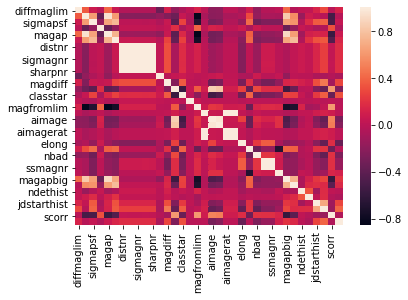

In [40]:
import seaborn as sn
sn.heatmap(corr_matrix, annot=False)